In [1]:
import pandas as pd

df = pd.read_csv("333836601.csv")
pd.set_option('display.max_columns', 100)
df = df.drop(['employees_created'], axis=1)
df = df.drop(['employee_id'], axis=1)
df["age"] = df["age"].fillna(df["age"].mean())
df["influx_route_midium"] = df["influx_route_midium"].fillna('null')
df["influx_route_small"] = df["influx_route_small"].fillna('null')
df_a = df.copy()
df_b = pd.get_dummies(df_a['influx_route_big'], drop_first = True)
df_c = pd.get_dummies(df_a['influx_route_midium'], drop_first = True)
df_d= pd.get_dummies(df_a['influx_route_small'], drop_first = True)
df_e= pd.get_dummies(df_a['device'], drop_first = True)

df = pd.concat([df, df_b, df_c, df_d, df_e], axis=1)
df = df.drop(['influx_route_big'], axis=1)
df = df.drop(['influx_route_midium'], axis=1)
df = df.drop(['influx_route_small'], axis=1)
df = df.drop(['device'], axis=1)

In [2]:
df.head()

,age,gender,entry_date_diffs,interview_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,DSP,SEO,twitter広告,その他,アフィリエイト,メルマガ,リスティング,提携媒体,GDN,GoogleMap,Google検索,KWターゲティング,LINE,TOP埋め込みEF,YDN,Yahoo検索,docomo,null,useful下部固定,webもり,アクセストレード,アフィリエイトB,キャリアパーク,フォロワーターゲティング,プレスコ,プロモツイート,メディパートナー,リマーケティング,...,infeed_remarketing,infeed_インタレストマッチ,infeed_ターゲティング,null,こだわり軸,セミナー,ターゲティング,ターゲティング_remarketing,ターゲティング_インタレストマッチ,ハローワーク軸,フォロワーターゲティング,フリーター軸,ミドルワード軸,メルマガ_登録半年以内_アプローチ+面談日程連絡待ち_求人紹介_転職無し,メルマガ_登録半年以内_アプローチ_ハタラクティブ魅力付け,メルマガ_登録半年以内_面談済み_就活ノウハウ_就活準備,メルマガ_登録半年以内_面談済み_求人紹介_残業無し推し,メルマガ_登録半年以前_面談済み_就活ノウハウ_就活全体,メルマガ_登録半年以前_面談済み_求人紹介_転職無し,メルマガ_面談済み_応募意思あり_CCテキストよびかけ,リターケティング,リマーケティング,友達紹介カード,地域軸,地域軸_未経験,大卒軸,就職軸_学歴KW軸,属性軸,属性軸_フリーター軸,属性軸_大卒軸,属性軸_既卒軸,属性軸_第二新卒軸,属性軸_高卒軸,手動プレースメント,指名検索軸,支援軸,既卒軸,正社員軸,相談軸,第二新卒軸,職種軸,自動プレースメント,自動メール_登録10日後経過面談未予約_カウンセラー紹介,自動メール_登録7日後経過面談未予約_就職成功事例紹介,興味関心ターゲティング,転職軸,雇用形態軸,面談,高卒軸,SP
0,18.0,1,17,11,0,0,5,0,0,1,0,0,1,0,0,0,0,1,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,29.0,0,5,5,6,7,37,1,1,0,0,0,1,0,0,0,0,1,0,1,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,25.0,0,16,16,1,0,8,0,0,0,1,0,1,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,25.0,1,2,2,1,0,22,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,21.0,0,0,0,3,2,15,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
df_train = df.copy()

#変数を配列へ変換
from sklearn.cross_validation import train_test_split

X = df_train.drop("objective_variable" , axis=1).values
y = df_train["objective_variable"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [32]:
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
import lightgbm as lgb


# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective' : 'binary',#2値分類
    'metric' : {'auc', 'binary_logloss'},
    'num_leaves' : 31,#葉の数(31, 200)
    'learning_rate' : 0.05,#結果に対する各ツリーの影響度を小さくする(小さいほどロバスト性が高く良い0.05, 0.005, 0.1）
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq': 5,
    'verbose' : 0
}

In [11]:
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1500,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)
				
from sklearn import metrics as mtr
%matplotlib inline
from matplotlib import pyplot as plt

# 予測
class_predict = gbm.predict(X_test, num_iteration=gbm.best_iteration)
#prob = model.predict_proba(X_test)[:,1]
#fpr, tpr, thresholds = mtr.roc_curve(y_test, prob,pos_label =1)

#print('テストデータに対する正解率： %.4f' %mtr.accuracy_score(y_test,class_predict))
print('roc-auc： %.4f' %mtr.roc_auc_score(y_test, class_predict))
print('log-loss： %.4f' %mtr.log_loss(y_test, class_predict))

[1]	valid_0's auc: 0.696655	valid_0's binary_logloss: 0.662117
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.701684	valid_0's binary_logloss: 0.656612
[3]	valid_0's auc: 0.713504	valid_0's binary_logloss: 0.65102
[4]	valid_0's auc: 0.717789	valid_0's binary_logloss: 0.645959
[5]	valid_0's auc: 0.717674	valid_0's binary_logloss: 0.641574
[6]	valid_0's auc: 0.720136	valid_0's binary_logloss: 0.637634
[7]	valid_0's auc: 0.721407	valid_0's binary_logloss: 0.633875
[8]	valid_0's auc: 0.722668	valid_0's binary_logloss: 0.632022
[9]	valid_0's auc: 0.723587	valid_0's binary_logloss: 0.628666
[10]	valid_0's auc: 0.727119	valid_0's binary_logloss: 0.624977
[11]	valid_0's auc: 0.728214	valid_0's binary_logloss: 0.622175
[12]	valid_0's auc: 0.729236	valid_0's binary_logloss: 0.619446
[13]	valid_0's auc: 0.730367	valid_0's binary_logloss: 0.616929
[14]	valid_0's auc: 0.731116	valid_0's binary_logloss: 0.614654
[15]	valid_0's auc: 0.733157	valid_0's binary_loglos

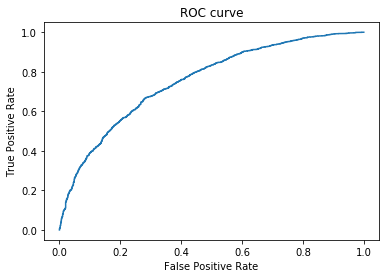

0.7548


In [12]:
%matplotlib inline
from sklearn import metrics as mtr
from matplotlib import pyplot as plt
from sklearn import metrics


y_pred = gbm.predict(X_test)

# AUC (Area Under the Curve) を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

#prob = model.predict_proba(X_test)[:,1]
#fpr, tpr, thresholds = mtr.roc_curve(y_test, prob,pos_label =1)

plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
print( '%.4f' %auc)

In [13]:
from sklearn.metrics import average_precision_score
average_precision = dict()

average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.82


TypeError: unsupported format string passed to dict.__format__

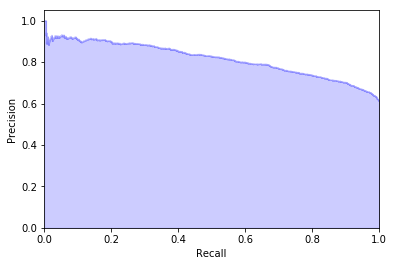

In [14]:
#PR曲線が書きたい。。
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
print( '%.4f' %auc)

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
#sklearn.metrics.average_precision_score

In [ ]:
Precisionは、0.8程度5人に一人は外れる..?(めちゃ精度いいやん、)

In [18]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

n_folds = 5
early_stopping = 10
params = {'eta': 0.02, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}


cv = lgb.cv(params, X_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)


TypeError: Traninig only accepts Dataset object

In [25]:
d_train = lgb.Dataset(X_train, label=y_train)

In [38]:
# Cross-validate
cv_results = lgb.cv(params, d_train, num_boost_round=1500, nfold=5, 
                    verbose_eval=10, early_stopping_rounds=10)

# https://www.kaggle.com/aharless/trying-to-do-k-fold-cv-on-lightgbm

[10]	cv_agg's auc: 0.718111 + 0.013585	cv_agg's binary_logloss: 0.625878 + 0.00312548
[20]	cv_agg's auc: 0.729436 + 0.0140531	cv_agg's binary_logloss: 0.604454 + 0.00498103
[30]	cv_agg's auc: 0.73498 + 0.011056	cv_agg's binary_logloss: 0.593038 + 0.00490954
[40]	cv_agg's auc: 0.737927 + 0.0118214	cv_agg's binary_logloss: 0.586329 + 0.00626727
[50]	cv_agg's auc: 0.740468 + 0.0114524	cv_agg's binary_logloss: 0.581945 + 0.00643979
[60]	cv_agg's auc: 0.74218 + 0.0113644	cv_agg's binary_logloss: 0.579035 + 0.00714614
[70]	cv_agg's auc: 0.742894 + 0.0119013	cv_agg's binary_logloss: 0.577399 + 0.00799417
[80]	cv_agg's auc: 0.744443 + 0.0117572	cv_agg's binary_logloss: 0.575631 + 0.00832878
[90]	cv_agg's auc: 0.74445 + 0.0115568	cv_agg's binary_logloss: 0.575078 + 0.00844086
[100]	cv_agg's auc: 0.745261 + 0.0116324	cv_agg's binary_logloss: 0.57426 + 0.00879703
[110]	cv_agg's auc: 0.745483 + 0.0116554	cv_agg's binary_logloss: 0.573979 + 0.0089718


In [40]:
y_pred = cv_results.predict(X_test)

# AUC (Area Under the Curve) を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

#prob = model.predict_proba(X_test)[:,1]
#fpr, tpr, thresholds = mtr.roc_curve(y_test, prob,pos_label =1)

plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
print( '%.4f' %auc)

AttributeError: 'dict' object has no attribute 'predict'

In [44]:
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['auc-mean']))
print('Best CV score:', cv_results['auc-mean'][-1])

Current parameters:
 {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': {'auc', 'binary_logloss'}, 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0}

Best num_boost_round: 109
Best CV score: 0.7456354852228041


### グリッド入れる